Kode som tar en url og lager oversikt


In [1]:
import pandas as pd
import re

def process_tromscup_results(url):
    # Step 1: Read HTML tables from the URL
    tables = pd.read_html(url)
    df = pd.DataFrame(tables[0])

    # Extract 'ar_klasse_verdi' from first cell of first row
    ar_klasse_verdi = df.iloc[0, 0]

    # Step 2: Change cell value at (1, 0) to "sammenlagt plassering"
    df.iloc[1, 0] = "sammenlagt plassering"

    # Step 3: Drop first row and reset index
    df = df.drop(0).reset_index(drop=True)

    # Step 4: Remove last row and reset index
    df = df.drop(df.index[-1]).reset_index(drop=True)

    # Step 5: Set first row as column headers and drop it
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])

    # Step 6: Extract values using regex function
    def extract_values(ar_klasse_verdi):
        kjonn_match = re.search(r'(Gutter|Menn|Kvinner|Jenter)', ar_klasse_verdi)
        kjonn = kjonn_match.group(0) if kjonn_match else None

        klasse_match = re.search(r'(\d{2}-\d{2}|Senior)', ar_klasse_verdi)
        klasse = klasse_match.group(0) if klasse_match else None

        sesong_match = re.search(r'(\d{4}/\d{4})', ar_klasse_verdi)
        sesong = sesong_match.group(0) if sesong_match else None

        return kjonn, klasse, sesong

    kjonn, klasse, sesong = extract_values(ar_klasse_verdi)

    # Step 7: Add new columns to DataFrame
    df['kjønn'] = kjonn
    df['klasse'] = klasse
    df['sesong'] = sesong

    # Step 8: Rearrange columns as desired
    cols = list(df.columns)
    insert_positions = {'kjønn': 4, 'klasse': 5, 'sesong': 6}

    for col, pos in insert_positions.items():
        cols.remove(col)
        cols.insert(pos, col)

    df = df[cols]

    # Step 9: Melt DataFrame to convert from wide to long format
    id_vars = ["sammenlagt plassering", "Navn", "Poeng", "Treff", "kjønn", "klasse", "sesong"]
    df_long = pd.melt(df, id_vars=id_vars, var_name="Konkuranse", value_name="utfall")

    # Step 10: Reorder and rename columns as needed
    df_long = df_long[id_vars + ["Konkuranse", "utfall"]]

    new_column_names = {
        'Konkuranse': 'konkuranse',
        'Navn': 'navn',
        'Poeng': 'total poeng',
        'Treff': 'total treff',
        'kjønn': 'kjønn',
        'klasse': 'klasse',
        'sesong': 'sesong',
        'utfall': 'tromscup poeng/treff'
    }

    df_long.rename(columns=new_column_names, inplace=True)

    # Step 11: Move 'Konkuranse' column to the front
    df_long = df_long[['konkuranse'] + [col for col in df_long.columns if col != 'konkuranse']]

    # Step 12: Extract 'plassering' and 'treff' from 'tromscup poeng/treff'
    df_long[['plassering', 'treff']] = df_long['tromscup poeng/treff'].str.split('/', expand=True)

    # Step 13: Map 'plassering' values using a mapping dictionary
    mapping = {
        100: 1, 80: 2, 60: 3, 50: 4, 45: 5, 40: 6, 36: 7, 32: 8, 29: 9, 26: 10,
        24: 11, 22: 12, 20: 13, 18: 14, 16: 15, 15: 16, 14: 17, 13: 18, 12: 19,
        11: 20, 10: 21, 9: 22, 8: 23, 7: 24, 6: 25, 5: 26, 4: 27, 3: 28, 2: 29, 1: 30
    }

    df_long['plassering'] = df_long['plassering'].astype(float).map(mapping)

    # Step 14: Convert 'plassering' and 'treff' columns to numeric type
    df_long['plassering'] = pd.to_numeric(df_long['plassering'], errors='coerce')
    df_long['treff'] = pd.to_numeric(df_long['treff'], errors='coerce')

    return df_long

# Example usage:



Test på kode

In [2]:
url = 'http://tromscup.com/index.php?k=MSen&sesong=7'
test = process_tromscup_results(url)

print(test.head())

                   konkuranse sammenlagt plassering             navn  \
0  Målselvs 01.12.2019 Sprint                    1.     Alexander Os   
1  Målselvs 01.12.2019 Sprint                    2.        Rune Skog   
2  Målselvs 01.12.2019 Sprint                    3.  Tor Espen Lynum   
3    Tromsø 07.12.2019 Normal                    1.     Alexander Os   
4    Tromsø 07.12.2019 Normal                    2.        Rune Skog   

  total poeng total treff kjønn  klasse     sesong tromscup poeng/treff  \
0         500          69  Menn  Senior  2019/2020                  NaN   
1         460          51  Menn  Senior  2019/2020                100/9   
2         260          32  Menn  Senior  2019/2020                  NaN   
3         500          69  Menn  Senior  2019/2020               100/19   
4         460          51  Menn  Senior  2019/2020                  NaN   

   plassering  treff  
0         NaN    NaN  
1         1.0    9.0  
2         NaN    NaN  
3         1.0   19.0  
4

Kode som generer url for klassene:

In [3]:
base_url = 'http://tromscup.com/index.php?'

# Define seasons and categories
seasons = range(1, 8)
categories = ['J13-14', 'J15-16', 'K17-19', 'K20-21', 'KSen', 'G13-14', 'G15-16', 'M17-19', 'M20-21', 'MSen', 'MilA']

# Generate URLs
urls = []
for sesong in seasons:
    for k in categories:
        url = f"{base_url}k={k}&sesong={sesong}"
        urls.append(url)

# Define seasons and categories for sesong 8-11
seasons_2 = range(8, 12)
categories_2 = ['J13-14', 'J15-16', 'K17-19', 'K20-22', 'KSen', 'G13-14', 'G15-16', 'M17-19', 'M20-22', 'MSen', 'MilA']

# Generate URLs
urls_2 = []
for sesong in seasons_2:
    for k in categories_2:
        url_2 = f"{base_url}k={k}&sesong={sesong}"
        urls_2.append(url_2)

all_urls = urls + urls_2

kjører alle url på funksjonen

In [4]:
all_results = []
for url in all_urls:
    try:
        result_df = process_tromscup_results(url)
        all_results.append(result_df)
        print(f"Processed URL: {url}")
    except Exception as e:
        print(f"Failed to process URL: {url}")
        print(e)

# Concatenate all result DataFrames into a single DataFrame
final_df = pd.concat(all_results, ignore_index=True)

Processed URL: http://tromscup.com/index.php?k=J13-14&sesong=1
Processed URL: http://tromscup.com/index.php?k=J15-16&sesong=1
Processed URL: http://tromscup.com/index.php?k=K17-19&sesong=1
Processed URL: http://tromscup.com/index.php?k=K20-21&sesong=1
Processed URL: http://tromscup.com/index.php?k=KSen&sesong=1
Processed URL: http://tromscup.com/index.php?k=G13-14&sesong=1
Processed URL: http://tromscup.com/index.php?k=G15-16&sesong=1
Processed URL: http://tromscup.com/index.php?k=M17-19&sesong=1
Processed URL: http://tromscup.com/index.php?k=M20-21&sesong=1
Processed URL: http://tromscup.com/index.php?k=MSen&sesong=1
Processed URL: http://tromscup.com/index.php?k=MilA&sesong=1
Processed URL: http://tromscup.com/index.php?k=J13-14&sesong=2
Processed URL: http://tromscup.com/index.php?k=J15-16&sesong=2
Processed URL: http://tromscup.com/index.php?k=K17-19&sesong=2
Processed URL: http://tromscup.com/index.php?k=K20-21&sesong=2
Processed URL: http://tromscup.com/index.php?k=KSen&sesong=2


In [5]:
df = final_df

split_columns = df['konkuranse'].str.extract(r'(?P<sted>.+?)\s+(?P<dato>\d{2}\.\d{2}\.\d{4})\s+(?P<konkurranse>.+)')

# Merge split columns into the original DataFrame
df = df.drop('konkuranse', axis=1).join(split_columns)

In [6]:
df['mesterskap'] = 'tromscup'
# Update 'mesterskap' to 'KM' if 'konkurranse' contains 'KM' or '(KM)'
df.loc[df['konkurranse'].str.contains(r'\bKM\b', case=False, na=False), 'mesterskap'] = 'KM'

# Remove 'KM' and '(KM)' from 'konkurranse'
df['konkurranse'] = df['konkurranse'].str.replace(r'\s*\(?KM\)?', '', case=False, regex=True).str.strip()



In [7]:
import numpy as np

# Define the conditions for the `klasse` and `konkurranse`
klasse_young = ['13-14', '15-16', '13-14', '15-16', 'Supersprint']
klasse_adult = ['17-19', '20-22','20-21','MSen', 'MilA']

# Function to calculate `bom`
def calculate_bom(row):
    if pd.isna(row['treff']):
        return np.nan
    if row['klasse'] in klasse_young:
        return 10 - row['treff']
    elif row['klasse'] in klasse_adult:
        if row['konkurranse'] == 'Sprint':
            return 10 - row['treff']
        elif row['konkurranse'] in ['Fellesstart', 'Normal']:
            return 20 - row['treff']
    return np.nan  # Default case

In [11]:
df['bom'] = df.apply(calculate_bom, axis=1)

In [8]:
new_order = ['dato','sesong','mesterskap', 'konkurranse','sted','navn','kjønn','klasse','plassering','treff','bom','sammenlagt plassering','total poeng','total treff','tromscup poeng/treff']

# Reorder the columns
df = df.reindex(columns=new_order)

In [13]:
filtered_df = final_df[final_df['navn'] == 'Eirik Silsand Gerhardsen']

# Display the filtered DataFrame
print(filtered_df)

                             konkuranse sammenlagt plassering  \
905           Målselv 01.12.2013 Normal                    9.   
927    Nordreisa 15.12.2013 Fellesstart                    9.   
949          Laksvatn 29.12.2013 Sprint                    9.   
971      Storsteinnes 05.01.2014 Sprint                    9.   
993          Bardu IL 01.02.2014 Sprint                    9.   
...                                 ...                   ...   
13445        Bardu 10.02.2024 KM Sprint                    3.   
13468   Bardu 11.02.2024 KM Fellesstart                    3.   
13491          Tromsø 18.02.2024 Normal                    3.   
13514        Bjerkvik 02.03.2024 Normal                    3.   
13537        Laksvatn 23.03.2034 Normal                    3.   

                           navn total poeng total treff   kjønn  klasse  \
905    Eirik Silsand Gerhardsen         264          55  Gutter   15-16   
927    Eirik Silsand Gerhardsen         264          55  Gutter   15-

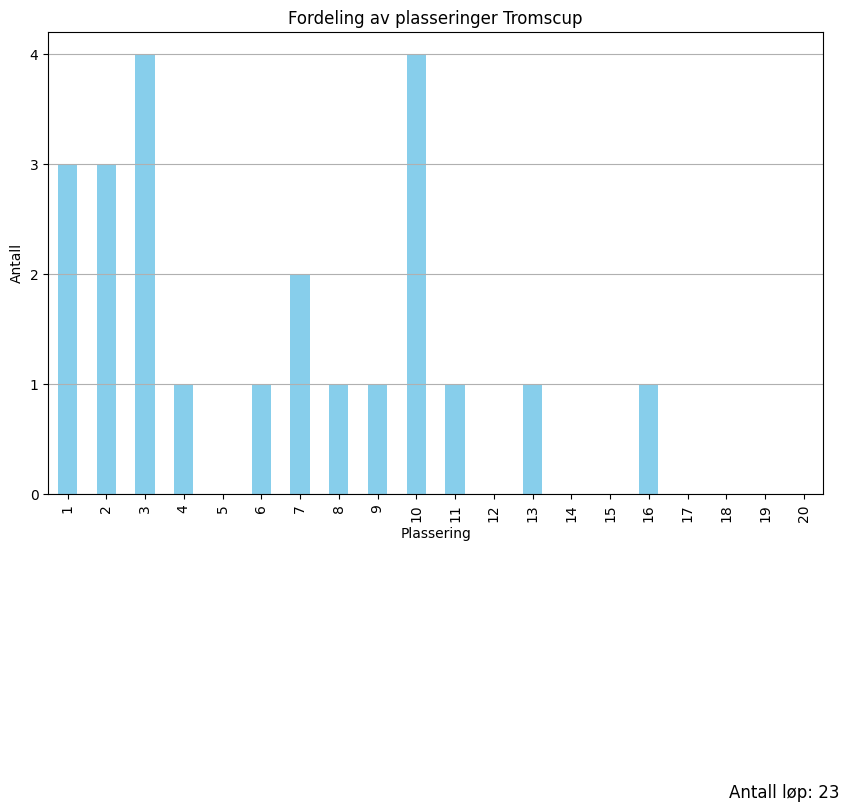

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
filtered_df = final_df[final_df['navn'] == 'Vebjørn Skjelmo Sæbø']
# Ensure all values from 1 to 20 are included in value_counts
value_counts = filtered_df['plassering'].value_counts().sort_index().reindex(range(1, 21), fill_value=0)

# Plotting the bar plot
plt.figure(figsize=(10, 6))  # Optional: adjust figure size

# Plotting bar chart
value_counts.plot(kind='bar', color='skyblue')
total_count = value_counts.sum()

# Adding titles and labels
plt.title('Fordeling av plasseringer Tromscup')
plt.xlabel('Plassering')
plt.ylabel('Antall')
plt.grid(axis='y') 
plt.yticks(range(0, value_counts.max() + 1))
plt.text(len(value_counts) - 1.5, -2.8, f'Antall løp: {total_count}', ha='center', va='bottom', fontsize=12)

# Display the plot
plt.show()
